In [61]:
%pylab inline
import pandas as pd
import seaborn as sns

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Populating the interactive namespace from numpy and matplotlib


# Model Evaluation

## Review of last class

- Goal was to predict the **response value** of an **unknown observation**
    - predict the species of an unknown iris
    - predict the position of an unknown NBA player
- Made predictions using KNN models with **different values of K**
- Need a way to choose the **"best" model**: the one that "generalizes" to "out-of-sample" data

**Solution:** Create a procedure that **estimates** how well a model is likely to perform on out-of-sample data and use that to choose between models.

**Note:** These procedures can be used with **any machine learning model**, not only KNN.

## Evaluation procedure #1: Train and test on the entire dataset

1. Train the model on the **entire dataset**.
2. Test the model on the **same dataset**, and evaluate how well we did by comparing the **predicted** response values with the **true** response values.

In [62]:
# read the NBA data into a DataFrame
url = '../data/NBA_players_2015.csv'
nba = pd.read_csv(url, index_col=0)

In [63]:
# map positions to numbers
nba['pos_num'] = nba.pos.map({'C':0, 'F':1, 'G':2})

In [64]:
# create feature matrix (X)
feature_cols = ['ast', 'stl', 'blk', 'tov', 'pf']
X = nba[feature_cols]

In [65]:
# create response vector (y)
y = nba.pos_num

### KNN (K=50)

In [66]:
# import the class
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=50)

# train the model on the entire dataset
knn.fit(X, y)

# predict the response values for the observations in X ("test the model")
knn.predict(X)

array([1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
       0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 1, 2,
       2, 2, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 1, 1, 2, 2, 2, 0, 0,
       2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1,
       1, 1,

In [67]:
# store the predicted response values
y_pred_class = knn.predict(X)

To evaluate a model, we also need an **evaluation metric:**

- Numeric calculation used to **quantify** the performance of a model
- Appropriate metric depends on the **goals** of your problem

Most common choices for classification problems:

- **Classification accuracy**: percentage of correct predictions ("reward function" since higher is better)
- **Classification error**: percentage of incorrect predictions ("loss function" since lower is better)

In this case, we'll use classification accuracy.

In [68]:
# compute classification accuracy
from sklearn import metrics
print(metrics.accuracy_score(y, y_pred_class))

0.665271966527


This is known as **training accuracy** because we are evaluating the model on the same data we used to train the model.

### KNN (K=1)

In [69]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
y_pred_class = knn.predict(X)
print(metrics.accuracy_score(y, y_pred_class))

1.0


### Problems with training and testing on the same data

- Goal is to estimate likely performance of a model on **out-of-sample data**
- But, maximizing training accuracy rewards **overly complex models** that won't necessarily generalize
- Unnecessarily complex models **overfit** the training data:
    - Will do well when tested using the in-sample data
    - May do poorly on out-of-sample data
    - Learns the "noise" in the data rather than the "signal"
    - From Quora: [What is an intuitive explanation of overfitting?](http://www.quora.com/What-is-an-intuitive-explanation-of-overfitting/answer/Jessica-Su)

**Thus, training accuracy is not a good estimate of out-of-sample accuracy.**

![1NN classification map](images/iris_01nn_map.png)

## Evaluation procedure #2: Train/test split

1. Split the dataset into two pieces: a **training set** and a **testing set**.
2. Train the model on the **training set**.
3. Test the model on the **testing set**, and evaluate how well we did.

What does this accomplish?

- Model can be trained and tested on **different data** (we treat testing data like out-of-sample data).
- Response values are known for the testing set, and thus **predictions can be evaluated**.

This is known as **testing accuracy** because we are evaluating the model on an independent "test set" that was not used during model training.

**Testing accuracy is a better estimate of out-of-sample performance than training accuracy.**

### Understanding the `train_test_split` function

In [70]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [71]:
# before splitting
print(X.shape)

# after splitting
print(X_train.shape)
print(X_test.shape)

(478, 5)
(358, 5)
(120, 5)


In [72]:
# before splitting
print(y.shape)

# after splitting
print(y_train.shape)
print(y_test.shape)

(478,)
(358,)
(120,)


![train_test_split](images/train_test_split.png)

### Using the train/test split procedure (K=1)

In [73]:
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [74]:
# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [75]:
# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.616666666667


### Repeating for K=50

In [76]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.675


### Baselines: Comparing testing accuracy with null accuracy

Null accuracy is the accuracy that could be achieved by **always predicting the most frequent class**. It is a benchmark against which you may want to measure your classification model.

In [77]:
# examine the class distribution
y_test.value_counts()

2    60
1    49
0    11
Name: pos_num, dtype: int64

In [78]:
# compute null accuracy
y_test.value_counts().head(1) / len(y_test)

2    0.5
Name: pos_num, dtype: float64

### Hyperparameter optimization: searching for the "best" value of K

In [79]:
# calculate TRAINING ERROR and TESTING ERROR for K=1 through 100

k_range = range(1, 101)
training_error = []
testing_error = []

for k in k_range:

    # instantiate the model with the current K value
    knn = KNeighborsClassifier(n_neighbors=k)

    # calculate training error
    knn.fit(X, y)
    y_pred_class = knn.predict(X)
    training_accuracy = metrics.accuracy_score(y, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # calculate testing error
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [80]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [81]:
# create a DataFrame of K, training error, and testing error
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

,testing error,training error
K,,
100,0.366667,0.351464
99,0.358333,0.347280
98,0.366667,0.345188
97,0.366667,0.347280
96,0.366667,0.345188


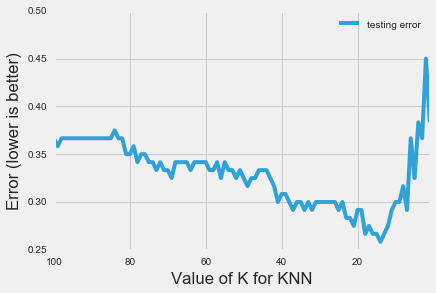

In [82]:
# plot the relationship between K (HIGH TO LOW) and TESTING ERROR
df.plot(y='testing error')
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')
plt.show()

In [83]:
# find the minimum testing error and the associated K value
df.sort_values(by='testing error').head()

,testing error,training error
K,,
14,0.258333,0.286611
13,0.266667,0.282427
18,0.266667,0.284519
16,0.266667,0.282427
15,0.266667,0.284519


What could we conclude?

- When using KNN on this dataset with these features, the **best value for K** is likely to be around 14.
- Given the statistics of an **unknown player**, we estimate that we would be able to correctly predict his position about 74% of the time.

### Training error versus testing error

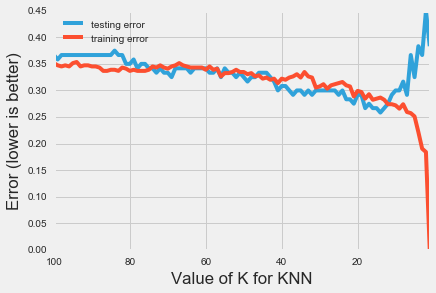

In [84]:
# plot the relationship between K (HIGH TO LOW) and both TRAINING ERROR and TESTING ERROR
df.plot()
plt.xlabel('Value of K for KNN')
plt.ylabel('Error (lower is better)')
plt.show()

- **Training error** decreases as model complexity increases (lower value of K)
- **Testing error** is minimized at the optimum model complexity

### Overfitting and Bias/Variance tradeoff

![Bias-variance tradeoff](images/training_testing_error.png)

![Bias-variance tradeoff](images/bias_variance.png)

## Making predictions on out-of-sample data

In [85]:
# instantiate the model with the best known parameters
knn = KNeighborsClassifier(n_neighbors=14)

# re-train the model with X and y (not X_train and y_train) - why?
knn.fit(X, y)

# make a prediction for an out-of-sample observation
knn.predict([[1, 1, 0, 1, 2]])

array([1])